# BERT Question Answering Bot



In [1]:
# !pip install transformers
!pip install "transformers==2.5.1"
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers


     |████████████████████████████████| 501kB 10.5MB/s 
     |████████████████████████████████| 102kB 7.5MB/s 
     |████████████████████████████████| 1.1MB 22.1MB/s 
     |████████████████████████████████| 890kB 44.0MB/s 
     |████████████████████████████████| 3.7MB 46.2MB/s 
     |████████████████████████████████| 7.0MB 47.8MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for boto3: filename=boto3-1.16.27-py2.py3-none-any.whl size=128454 sha256=86c955426733a333861e86c2f067dacbd2c27bb417b1f9670fb8155bd4e8c561
  Stored in directory: /root/.cache/pip/wheels/f7/4a/29/e5b74fd7012b8322191f5db368a910a78b013ce96bf4259d50
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=76e3793f6b9282f40d24f84acef1410b3111e941196bee26096d4c9c3f688a04
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built boto3 sacremoses
ERROR: botocore 1.19.27 has requirement urlli

In [2]:
import tensorflow as tf
import random
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel, AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertTokenizer, BertConfig
from tqdm import tqdm, trange
import textwrap
% matplotlib inline




In [3]:
# %%Nicole input
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla P100-PCIE-16GB'

## Import Data

In [5]:
from google.colab import drive
drive.mount('/drive',force_remount=True)

Mounted at /drive


In [6]:
!ls /drive/My\ Drive/qa_bot

cache	     models.py	  transformers		   utils_squad.py
data	     predictions  utils_preprocess.py	   visualizations.py
evaluate.py  __pycache__  utils_squad_evaluate.py


In [7]:
import sys
sys.path.append('/drive/My Drive/qa_bot')

In [8]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [9]:
input_file = '/drive/My Drive/qa_bot/data/train-v2.0.json'
examples_train = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [10]:
train_data = pd.DataFrame.from_records([vars(ex) for ex in examples_train])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


# Preprocessing

In [11]:
# Specify tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 700067.22B/s]


In [12]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
batch_size = 32

In [13]:
if not os.path.exists('/drive/My Drive/qa_bot/cache'):
    os.makedirs('/drive/My Drive/qa_bot/cache')
cached_features_file = '/drive/My Drive/qa_bot/cache/cache_train'

In [14]:
from utils_preprocess import create_features
features_train = create_features(cached_features_file = cached_features_file,
                           examples=examples_train,
                           tokenizer=tokenizer,
                           max_seq_length=max_seq_length,
                           doc_stride=doc_stride,
                           max_query_length=max_query_length,
                           is_training=True)

In [15]:
# Build training data
from utils_preprocess import generate_bert_loader_train
train_dataloader, len_train = generate_bert_loader_train(features_train, batch_size=batch_size, drop_last=True)

## Fine-Tune Model

In [16]:
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [17]:
# Specify architecture for output layer and whether to freeze bert parameters
from models import bert_mod
bert = bert_mod('bert-base-uncased')
# bert.freeze_param()

# model_name = "bert_linear"
# model = bert.bert_linear()

# model_name = "bert_linear_linear"
# model = bert.bert_linear_linear()

model_name = "bert_linear_act_drop"
model = bert.bert_linear_act_drop()

# model_name = "bert_linear_more_hidden"
# model = bert.bert_linear_more_hidden()

# model_name = "bert_linear_linear_linear"
# model = bert.bert_linear_linear_linear()

# model_name = "bert_linear_full"
# model = bert.bert_linear_full()

# model_name = "bert_linear_no_act"
# model = bert.bert_linear_no_act()

# model_name = "bert_conv_linear"
# model = bert.bert_conv_linear()

# print out model architecture
model.cuda()

100%|██████████| 440473133/440473133 [00:14<00:00, 30760793.12B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [18]:
global_step = 0
train_loss_set = []
tr_loss = 0.0
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.1},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.1}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon,betas=(0.9,0.999))

In [19]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len_train)
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader,desc="iterations",disable=False,position=0, leave=True)
    for step, batch in enumerate(epoch_iterator):
      if step < int(global_step) + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)
      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1


iterations:   0%|          | 0/4508 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 32
  Total optimization steps = 4508


/usr/local/lib/python3.6/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
Epoch: 100%|██████████| 1/1 [1:05:55<00:00, 3955.80s/it]


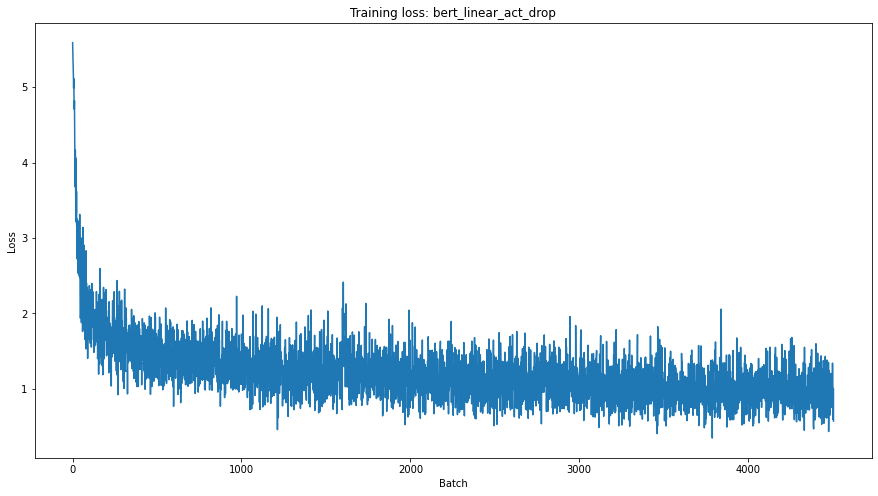

In [20]:
# Plot training loss
# model_name = "bert_linear_more_hidden (Unfrozen)"
plt.figure(figsize=(15,8))
plt.title("Training loss: "+ model_name)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Evaluate Result

In [21]:
input_file = '/drive/My Drive/qa_bot/data/dev-v2.0.json'
examples_val = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
batch_size = 32
cached_features_file = '/drive/My Drive/qa_bot/cache/cache_validation'

# Cache features
features_val = create_features(cached_features_file=cached_features_file,
                                    examples=examples_val,
                                    tokenizer=tokenizer,
                                    max_seq_length=max_seq_length,
                                    doc_stride=doc_stride,
                                    max_query_length=max_query_length,
                                    is_training=False)

In [22]:
from utils_preprocess import generate_bert_loader_validation
validation_dataloader, len_val = generate_bert_loader_validation(features_val, batch_size=batch_size, drop_last=True)

In [23]:
print(model_name)
path_val = '/drive/My Drive/qa_bot/data/dev-v2.0.json'
from evaluate import evaluate
results = evaluate(model, 
                   validation_dataloader, 
                   features_val,
                   examples_val,
                   tokenizer, 
                   path_val, 
                   len_val, 
                   batch_size,
                   device)



bert_linear_act_drop


Evaluating:   0%|          | 0/425 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 32


Evaluating: 100%|██████████| 425/425 [01:59<00:00,  3.55it/s]


{
  "exact": 71.46466773351301,
  "f1": 74.23526637223442,
  "total": 11873,
  "HasAns_exact": 60.391363022941974,
  "HasAns_f1": 65.9405056743483,
  "HasAns_total": 5928,
  "NoAns_exact": 82.50630782169891,
  "NoAns_f1": 82.50630782169891,
  "NoAns_total": 5945,
  "best_exact": 71.48993514697212,
  "best_exact_thresh": -0.10221469402313232,
  "best_f1": 74.24368884338726,
  "best_f1_thresh": -0.0029823780059814453
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

# Visualization

In [ ]:
# print("Example training data:")
# print()
# from utils_preprocess import print_squad_sample
# print_squad_sample(train_data)

In [ ]:
# Turn QA process into a function
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # # Report how long the input sequence is.
    # print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]).to(device), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids]).to(device)) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    answer = (answer if answer != '[CLS]' else 'No answer found')
    print('Answer: ' + answer + '')

def pretty_print(text_list, length = 14):
  lines = ([text_list[idx:idx+length] for idx in range(0, len(text_list), length)])
  for l in lines:
      print(" ".join(l))

In [ ]:
# Visualizing Scores
import matplotlib.pyplot as plt
import seaborn as sns
# Turn QA process into a function
def visualizing_scores(question, answer_text, include_alterview = False):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)
    # tokenizer
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # # Report how long the input sequence is.
    # print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]).to(device), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids]).to(device)) # The segment IDs to differentiate question from answer_text

    # ======== Plot ========
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    #sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (16,8)

    # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
    s_scores = start_scores.cpu().detach().numpy().flatten()
    e_scores = end_scores.cpu().detach().numpy().flatten()

    # We'll use the tokens as the x-axis labels. In order to do that, they all need
    # to be unique, so we'll add the token index to the end of each one.
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))
    # Create a barplot showing the start word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)
    plt.title('Start Word Scores: '+ question)
    plt.show()

    # Create a barplot showing the end word score for all of the tokens.
    ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

    # Turn the xlabels vertical.
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    # Turn on the vertical grid to help align words to scores.
    ax.grid(True)
    plt.title('End Word Scores: '+ question)
    plt.show()


## Alternative view: display start score and end score together
    if include_alterview:
      scores = []
      for (i, token_label) in enumerate(token_labels):

          # Add the token's start score as one row.
          scores.append({'token_label': token_label, 
                        'score': s_scores[i],
                        'marker': 'start'})
          
          # Add  the token's end score as another row.
          scores.append({'token_label': token_label, 
                        'score': e_scores[i],
                        'marker': 'end'})
      df = pd.DataFrame(scores)

      # Draw a grouped barplot to show start and end scores for each word.
      # The "hue" parameter is where we tell it which datapoints belong to which
      # of the two series.
      g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                      kind="bar", height=6, aspect=4)

      # Turn the xlabels vertical.
      g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

      # Turn on the vertical grid to help align words to scores.
      g.ax.grid(True)



In [28]:
# from transformers import BertForQuestionAnswering
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [29]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 
attention_abstract = "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data."
print(wrapper.fill(attention_abstract))

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, based
solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to be
superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-
German translation task, improving over the existing best results, including
ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task,
our model establishes a new single-model state-of-the-art BLEU score of 41.8
after training for 3.5 days on eight GPUs, a small fraction of the training
costs of the best models from the literature. We show that the Transform

In [30]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [31]:
import torch
question = "What is the Transformer based on?"
answer_question(question, attention_abstract)

Answer: attention mechanisms


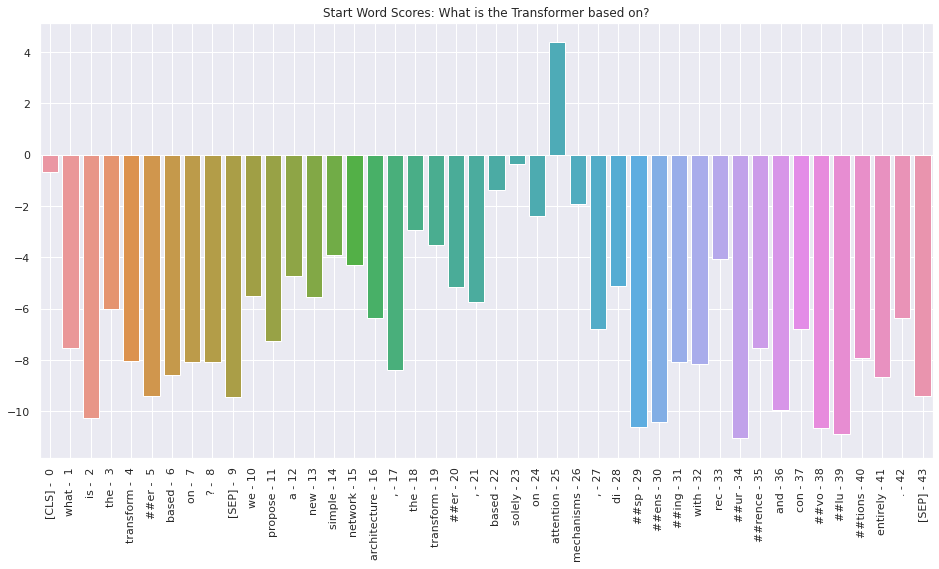

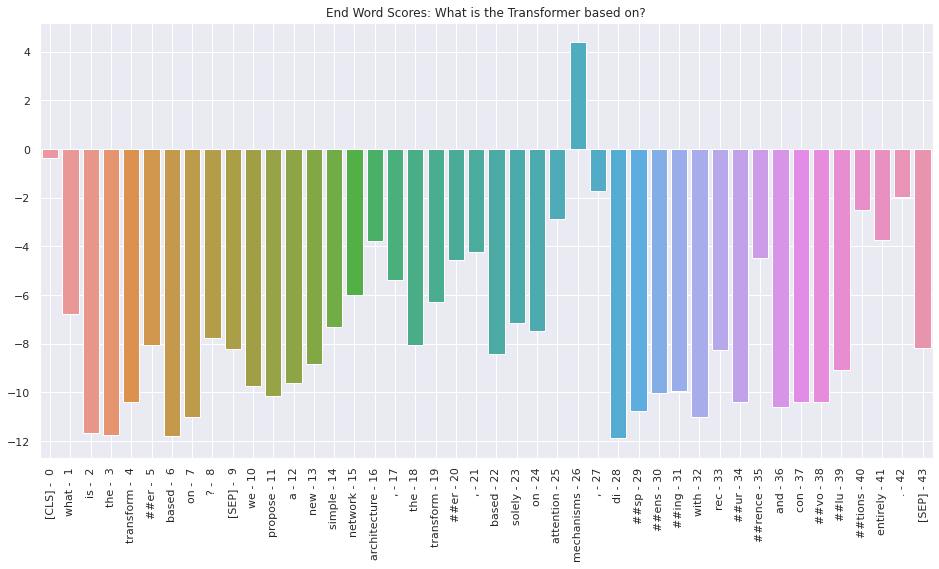

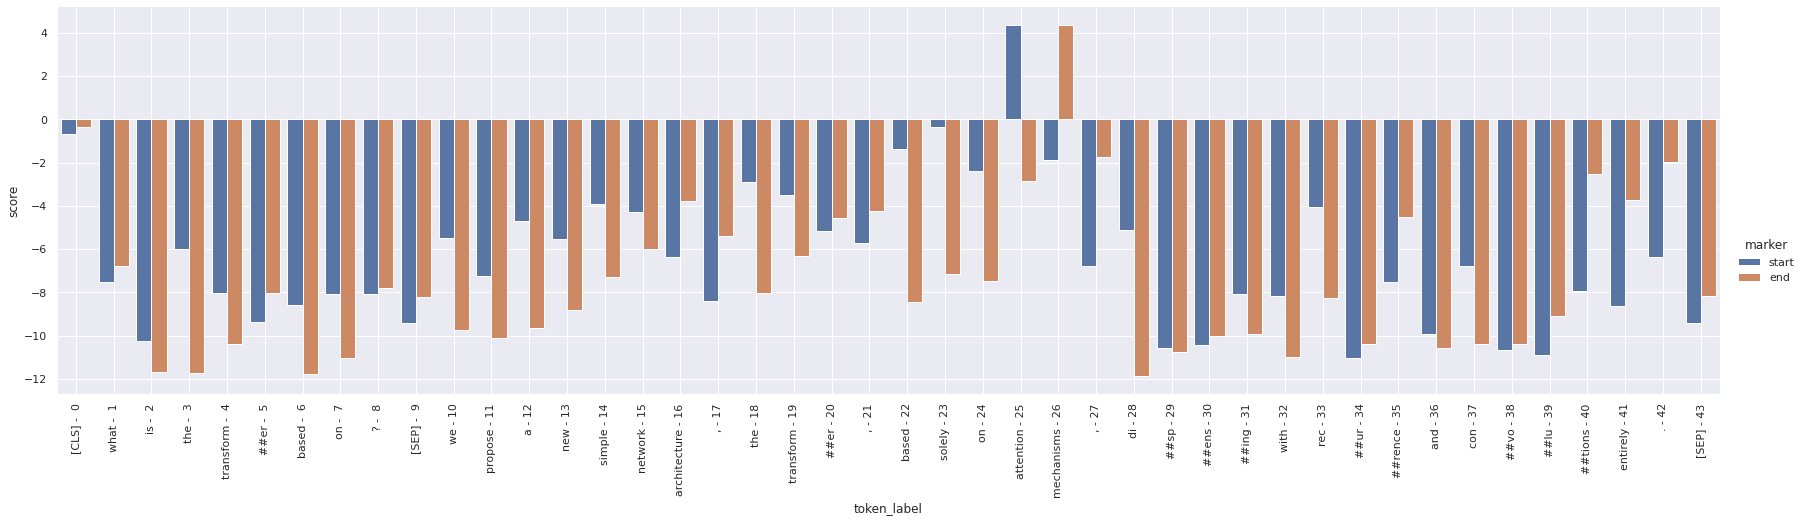

In [32]:
## Visualize start and end scores
# Here we use a span from the whole context for better and clearer image
visual_span = "We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely."
visualizing_scores(question, visual_span, include_alterview=True)

In [48]:
question = "What machine translation tasks do we practice?"
answer_question(question, attention_abstract)

Answer: No answer found


In [47]:
question = "What BLEU do we achieve?"
answer_question(question, attention_abstract)

Answer: 28


In [42]:
question = "What strengths of these models do the experiments show?"
answer_question(question, attention_abstract)

Answer: complex recurrent or convolutional neural networks
